## Import Models and Functions

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
%matplotlib inline
import math
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [1]:
from utils import *
from models import ResNetV1, ResNetV2, DenseNet, Cifar10, VGG, Inception, AlexNet  #import * not working properly
from tf_modules import *

Using TensorFlow backend.


## Import Dataset

In [3]:
from tensorflow.keras.datasets import cifar10

(train_data, train_labels), (test_x, test_y) = cifar10.load_data()

num_classes = 10
train_labels_cls = np_utils.to_categorical(train_labels,num_classes)
test_y_cls = np_utils.to_categorical(test_y,num_classes)

print("Size of:")
print("- Training-set:\t\t{}".format(len(train_data)))
print("- Test-set:\t\t{}".format(len(test_x)))

Size of:
- Training-set:		50000
- Test-set:		10000


In [4]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

class_names = load_label_names()

def label_to_array(cls_true):
    true = cls_true.tolist()
    true_label = []
    for l in true:
        true_label += l
    return true_label
    

In [5]:
#Data Dimensions

# CIFAR-10 images are 32 pixels in each dimension.
img_size = 32

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images:
num_channels = 3

# Number of classes, one class for each of 10 digits.
num_classes = 10

# Define input shape of data
input_shape = (img_size,img_size,num_channels)

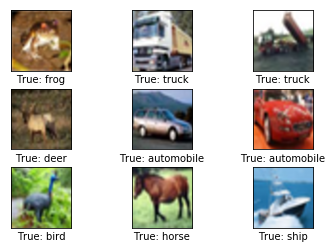

In [6]:
# Get the first 9 images from the train-set.
images = train_data[0:9]

# Get the true classes for those images.
cls_true = train_labels[0:9]
cls_true = label_to_array(cls_true)

# Plot the images and labels using our helper-function above.
plot_images(images, cls_true, class_names=class_names) 


In [7]:
# Split train-data into train and validation sets
from sklearn.model_selection import train_test_split

train_x, validation_x, train_y, validation_y = train_test_split(train_data, train_labels_cls,
                                                                test_size=0.2, random_state=42)

In [8]:
# Mean Normalize text
subtract_pixel_mean = True
crop_images = False  # randomly crop batches of training data

print ('Preparing data.....')
train_x, validation_x, test_x = data_prep(train_x, validation_x, test_x, subtract_pixel_mean)

if (crop_images):
    train_x = augment_batches(train_x, batch_size=128)

Preparing data.....


## Create Model

In [9]:
# Model
print('==> Building model..')
model = Cifar10.cifar_model() # works better with Adam optimizer
# model = AlexNet.alexnet()
# model = VGG.vgg('VGG19')
# model = ResNetV1.resnet(depth) # a multiple of 6n+2(e.g. 20, 32 etc.)
# model = ResNetV2.resnet(depth) # a multiple of 9n+2(e.g. 56, 110 etc.)
# model = Inception.inception()
# model = DenseNet.densenet(model, growth_rate=12, compression=0.5)  #growth_rate can be 12,32,40
                                                                     #(for cifar-10 use gr=12)

==> Building model..


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

### Optimizer

In [ ]:
num_epochs = 300

# Initialize the optimizer and compile the model
optimizer = SGD(lr=0.00, momentum=0.9, decay=5e-4)

model.compile(loss='categorical_crossentropy', optimizer=optimizer,
             metrics=['accuracy'])


## Decay Function

In [4]:
# Define decay function
  
def decay_fn(epoch, lr):
    if epoch < int(num_epochs*0.5):
        return 0.1
    elif epoch >= int(num_epochs*0.5) and epoch < int(num_epochs*0.75):
        return 0.01
    else:
        return 0.001

# learning schedule callback
lrate = tf.keras.callbacks.LearningRateScheduler(decay_fn)
callbacks_list = [lrate]

In [ ]:
# Train with data augmentation
data_augmentation = False

### Training Model

In [ ]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    h = model.fit(train_x, train_y,
                  batch_size = 64,
                  validation_data=(validation_x, validation_y),
                  callbacks=callbacks_list, 
                  epochs = num_epochs,
                  verbose = 1)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random zoom
        zoom_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(train_x)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(train_x, train_y,
                                     batch_size=64),
                                     validation_data=(validation_x, validation_y),
                                     epochs=num_epochs, verbose=1, workers=4,
                                     callbacks=callbacks_list)

In [5]:
result = model.evaluate(test_x, test_y_cls)

NameError: name 'model' is not defined

In [13]:
#Predict on test_set
pred_y = model.predict(test_x)
pred_cls = np.argmax(pred_y, axis=1)

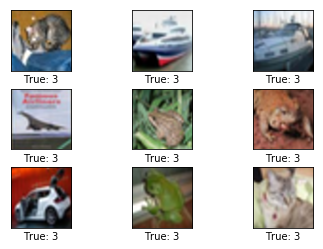

In [14]:
#Some predicted Images
# Get the first 9 images from the test-set.
images = test_x[0:9]

# Get the true classes for those images.
cls_true = test_y[0:9]
cls_true = label_to_array(cls_true)

#Get Predicted Classes
cls_pred = pred_cls[0:9]
cls_pred = cls_pred.tolist()

# Plot the images and labels using our helper-function above.
plot_images(images, cls_true, cls_pred)